Preparing the dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import numpy as np

df = pd.read_csv('housing.csv')

df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

df.fillna(0, inplace=True)

df['median_house_value'] = df['median_house_value'].apply(lambda x: np.log(x+1))


In [2]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del X_train['median_house_value']
del X_val['median_house_value']
del X_test['median_house_value']

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

Question 1

In [3]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

most_important_feature = dv.feature_names_[np.argmax(dt.feature_importances_)]
print(f"The most important feature used for splitting is: {most_important_feature}")


The most important feature used for splitting is: ocean_proximity=<1H OCEAN


In [4]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Question 2

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on validation set: {rmse}")


RMSE on validation set: 0.24518772479229906


Question 3

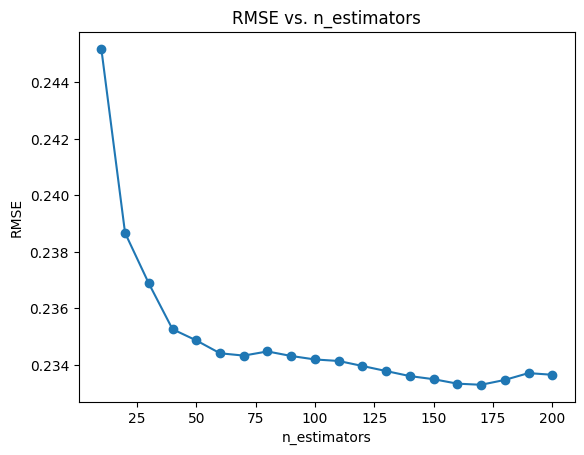

The RMSE stops improving after n_estimators value of: 170


In [7]:
estimators_values = list(range(10, 201+1, 10))
rmse_values = []

for n in estimators_values:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)

plt.plot(estimators_values, rmse_values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. n_estimators')
plt.show()

min_rmse = min(rmse_values)
min_rmse_index = rmse_values.index(min_rmse)
best_n_estimators = estimators_values[min_rmse_index]

print(f"The RMSE stops improving after n_estimators value of: {best_n_estimators}")


Question 4

In [8]:
max_depth_values = [10, 15, 20, 25]
estimators_values = list(range(10, 201+1, 10))

best_rmse = float('inf')  # Set an initial high value for RMSE
best_max_depth = None

for depth in max_depth_values:
    for n in estimators_values:
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_depth = depth

print(f"The best max_depth is: {best_max_depth}")


The best max_depth is: 25


Question 5

In [9]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, df_train['median_house_value'])

importances = rf.feature_importances_

most_important_index = np.argmax(importances)
most_important_feature = dv.feature_names_[most_important_index]

print(f"The most important feature is: {most_important_feature}")


The most important feature is: median_income


Question 6

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert the train and validation datasets to DMatrix format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Watchlist to observe the performance on validation set
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Train with eta=0.3
xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model_03 = xgb.train(xgb_params_03, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)
y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(df_val['median_house_value'], y_pred_03))

# Train with eta=0.1
xgb_params_01 = xgb_params_03.copy()
xgb_params_01['eta'] = 0.1
model_01 = xgb.train(xgb_params_01, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)
y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(df_val['median_house_value'], y_pred_01))

print(f"RMSE for eta=0.3: {rmse_03}")
print(f"RMSE for eta=0.1: {rmse_01}")


RMSE for eta=0.3: 0.228623199980106
RMSE for eta=0.1: 0.23208927121609343
